In [1]:
import tensorflow as tf
 
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# 장 마감 가격 예측

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr

%matplotlib inline
warnings.filterwarnings('ignore')



In [3]:
stock = fdr.DataReader('005930')

In [4]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-04-13,83000,84500,82800,84000,15238206,0.009615
2021-04-14,84000,84300,83400,84000,13794652,0.000000
2021-04-15,83700,84500,83400,84100,16377412,0.001190
2021-04-16,84700,84700,83600,83900,15429522,-0.002378
2021-04-19,83800,84000,83300,83400,12509112,-0.005959


Text(0, 0.5, 'price')

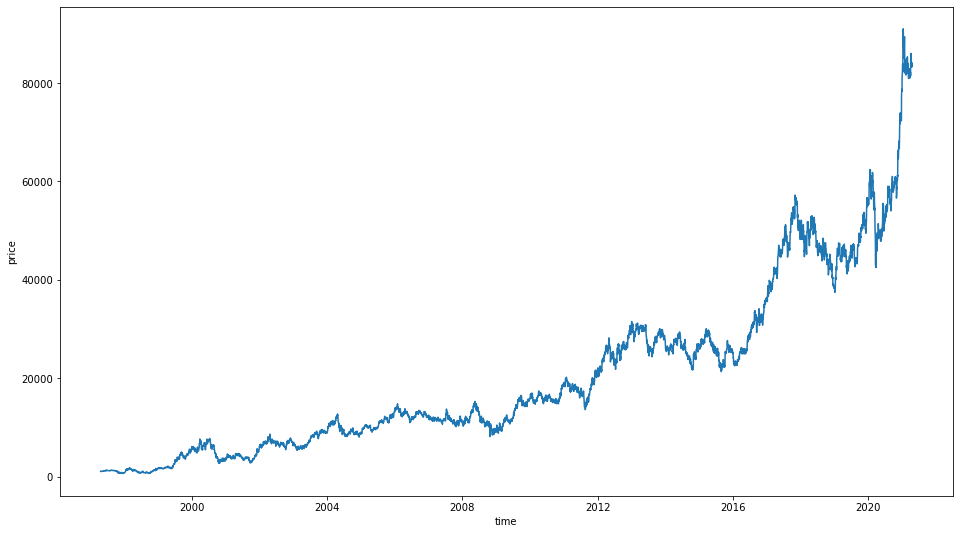

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

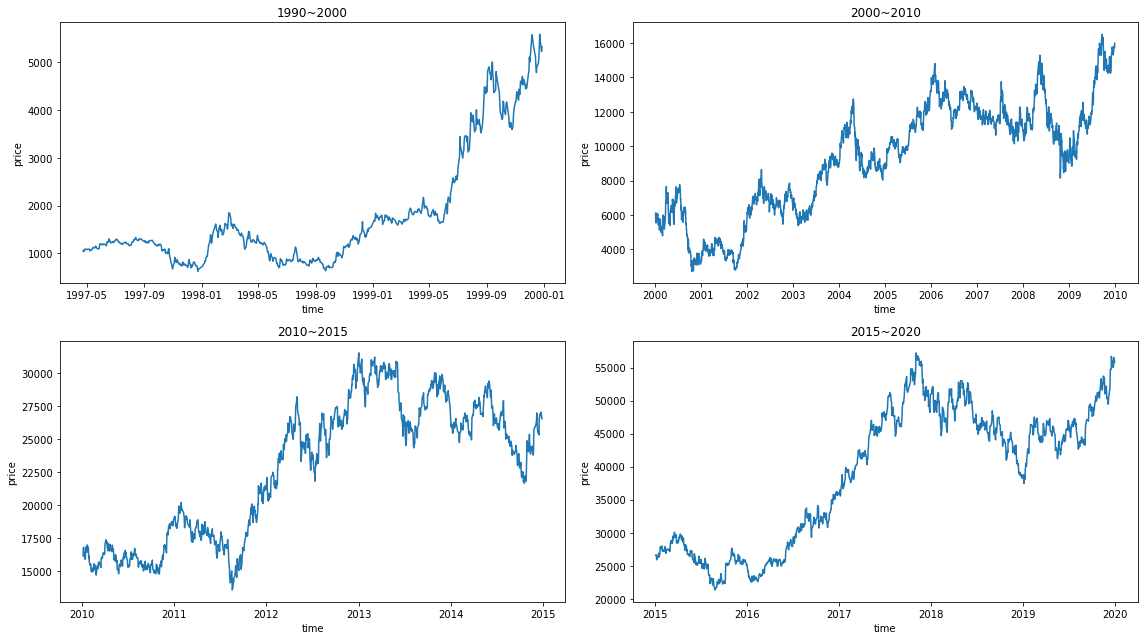

In [6]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [7]:
"""
데이터 전처리 -주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 정규화(Normalization) 수행
"""
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[1.18161683e-02, 1.10950413e-02, 1.17541899e-02, 4.79125402e-03,
        9.36270395e-04],
       [1.18161683e-02, 1.11157025e-02, 1.17430168e-02, 4.79125402e-03,
        9.18984756e-04],
       [1.17165006e-02, 1.09297521e-02, 1.15754190e-02, 4.58101424e-03,
        8.61402869e-04],
       ...,
       [9.26910299e-01, 8.72933884e-01, 9.31843575e-01, 9.23649763e-01,
        1.81354283e-01],
       [9.37984496e-01, 8.75000000e-01, 9.34078212e-01, 9.21436712e-01,
        1.70857881e-01],
       [9.28017719e-01, 8.67768595e-01, 9.30726257e-01, 9.15904086e-01,
        1.38518897e-01]])

In [8]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,Open,High,Low,Close,Volume
0,0.011816,0.011095,0.011754,0.004791,0.000936
1,0.011816,0.011116,0.011743,0.004791,0.000919
2,0.011717,0.010930,0.011575,0.004581,0.000861
3,0.011539,0.011198,0.011620,0.005068,0.000899
4,0.012204,0.011384,0.012112,0.005167,0.001056
...,...,...,...,...,...
5995,0.919158,0.872934,0.925140,0.922543,0.168739
5996,0.930233,0.870868,0.931844,0.922543,0.152754
5997,0.926910,0.872934,0.931844,0.923650,0.181354
5998,0.937984,0.875000,0.934078,0.921437,0.170858


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [52]:
x_train

,Open,High,Low,Volume
0,0.011816,0.011095,0.011754,0.000936
1,0.011816,0.011116,0.011743,0.000919
2,0.011717,0.010930,0.011575,0.000861
3,0.011539,0.011198,0.011620,0.000899
4,0.012204,0.011384,0.012112,0.001056
...,...,...,...,...
4795,0.284164,0.268182,0.284693,0.002627
4796,0.287708,0.269215,0.289385,0.002802
4797,0.287929,0.268802,0.284469,0.003044
4798,0.287265,0.267975,0.284693,0.002285


In [10]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [11]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [85]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    print("series: ",series)
    ds = tf.data.Dataset.from_tensor_slices(series)
    print("slice ds: ",ds)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    print("window with ds: ", ds)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    
    print("flat_map with ds: ",ds)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    
    print("final: ",ds)
    return ds.batch(batch_size).prefetch(1)

In [90]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train[0], WINDOW_SIZE, BATCH_SIZE, True)
#test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

series:  tf.Tensor([0.00479125], shape=(1,), dtype=float64)
slice ds:  <TensorSliceDataset shapes: (), types: tf.float64>
window with ds:  <WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorShape([]))>
flat_map with ds:  <FlatMapDataset shapes: (None,), types: tf.float64>
final:  <MapDataset shapes: ((None,), ()), types: (tf.float64, tf.float64)>


In [15]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 32)            192       
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [18]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [19]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
150/150 [==============================] - 5s 13ms/step - loss: 1.9779e-04 - mse: 3.9557e-04 - val_loss: 0.0035 - val_mse: 0.0071

Epoch 00001: val_loss improved from inf to 0.00353, saving model to tmp\ckeckpointer.ckpt
Epoch 2/50
150/150 [==============================] - 1s 5ms/step - loss: 1.0165e-05 - mse: 2.0330e-05 - val_loss: 0.0036 - val_mse: 0.0072

Epoch 00002: val_loss did not improve from 0.00353
Epoch 3/50
150/150 [==============================] - 1s 6ms/step - loss: 9.6223e-06 - mse: 1.9245e-05 - val_loss: 0.0033 - val_mse: 0.0065

Epoch 00003: val_loss improved from 0.00353 to 0.00326, saving model to tmp\ckeckpointer.ckpt
Epoch 4/50
150/150 [==============================] - 1s 5ms/step - loss: 9.4352e-06 - mse: 1.8870e-05 - val_loss: 0.0031 - val_mse: 0.0062

Epoch 00004: val_loss improved from 0.00326 to 0.00312, saving model to tmp\ckeckpointer.ckpt
Epoch 5/50
150/150 [==============================] - 1s 5ms/step - loss: 9.6867e-06 - mse: 1.9373e-05 - v

In [84]:
history.history['loss']

[0.00010691014904296026,
 1.8583086784929037e-05,
 1.7489985111751594e-05,
 1.701404107734561e-05,
 1.8650429410627112e-05,
 1.627362689760048e-05,
 1.8158461898565292e-05,
 1.6196354408748448e-05,
 1.4787644431635272e-05,
 1.5180562513705809e-05,
 1.5491672456846572e-05,
 1.3310080248629674e-05,
 1.3329630746738985e-05,
 1.3831232536176685e-05,
 1.2779214557667729e-05,
 1.4362766705744434e-05,
 1.3826338545186445e-05,
 1.3504876733350102e-05,
 1.1722263479896355e-05,
 1.1573483789106831e-05,
 1.1627656931523234e-05,
 1.2454470379452687e-05,
 1.0576754903013352e-05,
 1.1256556717853528e-05,
 1.141314805863658e-05,
 1.2141056686232332e-05,
 1.2094107660232112e-05,
 1.1310348781989887e-05,
 1.033974695019424e-05,
 1.0350039701734204e-05,
 1.0478676813363563e-05,
 9.964798664441332e-06,
 1.038034497469198e-05,
 1.0609665878291707e-05,
 9.82308392849518e-06]

In [20]:
model.load_weights(filename)

In [25]:
pred = model.predict(test_data)


In [26]:
pred.shape

(1180, 1)

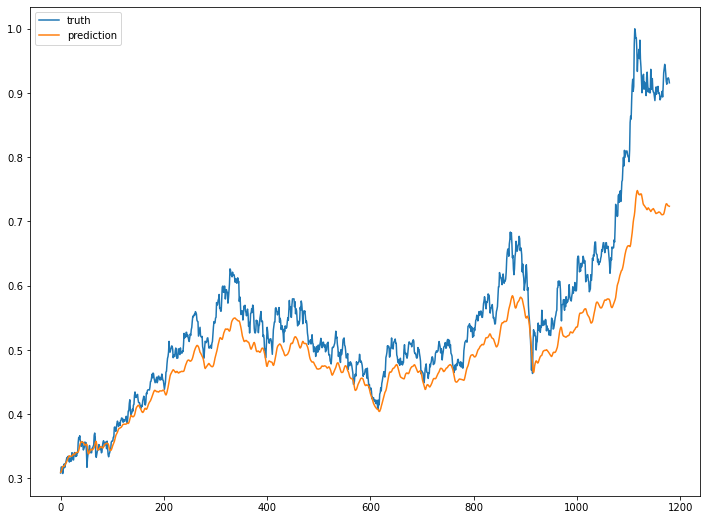

In [80]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='truth')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()